# Policy Gradient

# Import

In [1]:
import gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam

# Environment

In [2]:
env = gym.make('CartPole-v0').env

In [3]:
env.observation_space

Box(4,)

In [4]:
env.action_space

Discrete(2)

# Neural Network

In [5]:
def network(*, n_input, n_output, n_hidden=32, hidden_layers=1, 
            activation=nn.Tanh, output_activation=nn.Identity):
    layers = [nn.Linear(n_input, n_hidden), activation()]
    for _ in range(hidden_layers):
        layers += [nn.Linear(n_hidden, n_hidden), activation()]
    layers += [nn.Linear(n_hidden, n_output), output_activation()]
    return nn.Sequential(*layers)    

In [6]:
net = network(
    n_input=env.observation_space.shape[0], 
    n_hidden=128, 
    n_output=env.action_space.n)

In [7]:
net

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=2, bias=True)
  (5): Identity()
)

# Buffer

In [8]:
class Buffer:
    def __init__(self, maxlen):
        self._traj_rewards = 0
        self._cache = []
        self._memory = []
    
    @property
    def size(self): return len(self._memory)
    
    def cache(self, state, action, reward, next_state, done):
        self._traj_rewards += reward
        self._cache.append([state, action, reward, next_state, done])
    
    def flush(self):
        self._memory += [sample + [self._traj_rewards] for sample in self._cache]
        self._traj_rewards = 0
        self._cache = []
        
    def get_batch(self):
        states, actions, rewards, next_states, dones, traj_rewards = np.array(self._memory).transpose()         
        states, next_states = np.stack(states), np.stack(next_states)
        actions, traj_rewards = actions.astype(int), traj_rewards.astype(float)
        return states, actions, rewards, next_states, dones, traj_rewards
    
    def clear(self):
        self._memory = []

# Agent

In [9]:
class Agent:
    def __init__(self, env):
        self._env = env
        self._buffer = Buffer(5000)
        self._logits_net = network(n_input=env.observation_space.shape[0], 
                                   n_hidden=32, 
                                   n_output=env.action_space.n)
        self._optimizer = Adam(self._logits_net.parameters(), lr=0.02)

    def policy(self, state):
        state = torch.as_tensor(state, dtype=torch.float32)
        return Categorical(logits=self._logits_net(state))
    
    def choose_action(self, state, *, epilson=0.5):        
        if np.random.random()>epilson:
            return self._env.action_space.sample()
        else:
            return self.policy(state).sample().item()

In [10]:
class Agent(Agent):
    def play(self, *, n_steps=200, render=False):
        state = env.reset()
        done = False
        rewards = 0
        for i_steps in range(1, n_steps+1):
            action = self.choose_action(state, epilson=1)
            next_state, reward, done, info = env.step(action)            
            rewards += reward
            state = next_state
            if render: 
                env.render()
            if done: 
                break
        if render: 
            print(f'Steps taken: {i_steps}, rewards earned: {rewards}')
            env.close()
        else:
            return rewards

In [11]:
class Agent(Agent):
    def train(self):
        states, actions, rewards, next_states, dones, traj_rewards = self._buffer.get_batch()
        states = torch.as_tensor(states, dtype=torch.float32)
        actions = torch.as_tensor(actions, dtype=torch.int32)
        traj_rewards = torch.as_tensor(traj_rewards, dtype=torch.float32)
        # gradient ascent
        self._optimizer.zero_grad()        
        logp = self.policy(states).log_prob(actions)
        batch_loss = -(logp*traj_rewards).mean()
        batch_loss.backward()
        self._optimizer.step()
        return batch_loss.detach().numpy()

In [12]:
class Agent(Agent):
    def run(self, n_eps=100, n_steps=200, batch_size=2500):
        scores = deque(maxlen=10)
        for i_eps in range(1, n_eps+1):
            while True:
                state = env.reset()
                done = False
                for i_steps in range(1,n_steps+1):
                    action = self.choose_action(state, epilson=1)
                    next_state, reward, done, info = env.step(action)
                    self._buffer.cache(state, action, reward, next_state, done)
                    state = next_state 
                    if done: break
                self._buffer.flush()
                if self._buffer.size>=batch_size: 
                    break
            self.train()
            self._buffer.clear()
            if i_eps%1==0:
                scores.append(self.play())
            if i_eps%1==0:
                print('#', end='')
            if i_eps%1==0:            
                mean_score = sum(scores)/len(scores)
                print(f' | Episode {i_eps:>4d} | mean rewards: {mean_score:.1f}')
                if mean_score>=195:
                    print(f'\nMean score of {mean_score:.1f} is considered solved.')
                    break    

In [13]:
agent = Agent(env)

In [14]:
agent.run()

# | Episode    1 | mean rewards: 15.0
# | Episode    2 | mean rewards: 24.5
# | Episode    3 | mean rewards: 49.7
# | Episode    4 | mean rewards: 43.8
# | Episode    5 | mean rewards: 56.4
# | Episode    6 | mean rewards: 62.7
# | Episode    7 | mean rewards: 65.6
# | Episode    8 | mean rewards: 65.9
# | Episode    9 | mean rewards: 65.7
# | Episode   10 | mean rewards: 71.4
# | Episode   11 | mean rewards: 78.2
# | Episode   12 | mean rewards: 84.7
# | Episode   13 | mean rewards: 80.7
# | Episode   14 | mean rewards: 86.5
# | Episode   15 | mean rewards: 80.9
# | Episode   16 | mean rewards: 81.1
# | Episode   17 | mean rewards: 84.4
# | Episode   18 | mean rewards: 89.4
# | Episode   19 | mean rewards: 94.8
# | Episode   20 | mean rewards: 102.5
# | Episode   21 | mean rewards: 114.2
# | Episode   22 | mean rewards: 124.3
# | Episode   23 | mean rewards: 138.3
# | Episode   24 | mean rewards: 149.9
# | Episode   25 | mean rewards: 164.8
# | Episode   26 | mean rewards: 175.2
# | E

# Evaluation

In [15]:
agent.play(render=True)

Steps taken: 200, rewards earned: 200.0


# Comment

I used the tutorial from Openai Spinning Up to implement the policy gradient method. In each training loop, we adjust the gradient of the policy neural network according to:

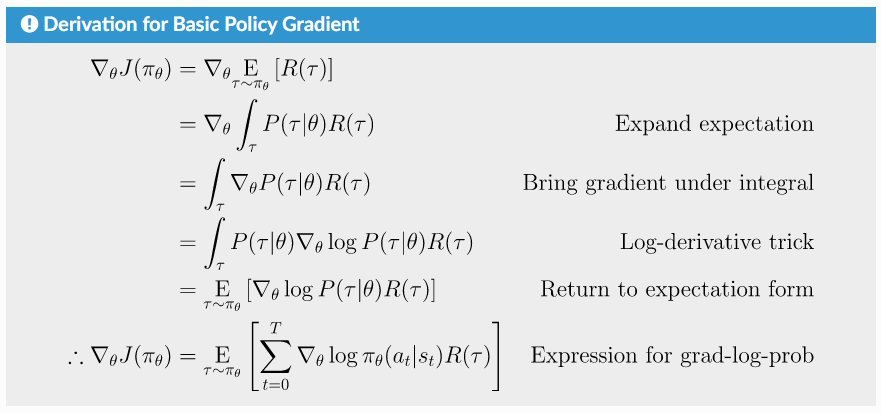

Source: <https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#part-3-intro-to-policy-optimization>

* Policy Gradient directly optimize the policy function, i.e. the derivative of expected rewards with respect to each parameter of the network.
* The model converge faster than using DQN.